In [1]:
import pandas as pd
import numpy as np
import csv

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

import spacy

In [2]:
# Load data frames
df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv', sep=',')

In [3]:
# Explore data set
df_train.head(15)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Observation :

This is a binary classification project, target is whether 0 or 1. The mean for target is ~ 0.43, so the number of examples for each class is different.
Let's evaluate the class distribution :

# data visualization

In [5]:
# data visualization

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('ggplot')
sns.set_theme()

### Class distribution

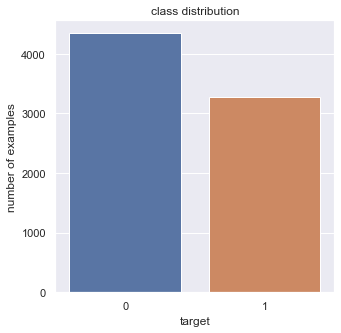

In [6]:
# Class distribution
customized_palette = [sns.color_palette()[0], sns.color_palette()[1]] # blue for false disasters and green for real disasters

plt.figure(figsize=(5, 5))

ax = sns.barplot(x=df_train['target'].value_counts().index,
                 y=df_train['target'].value_counts(),
                 palette=customized_palette)
ax.set(xlabel='target', ylabel='number of examples', title='class distribution')
# Other method
# plt.gca().set_ylabel('number of examples') # gca = get current axis

plt.show()

In [7]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Amongst a total of 7613 tweets, 3271 are about a real disaster (0.43%), and 4342 aren't (0.57%).

### Number of characters in tweets

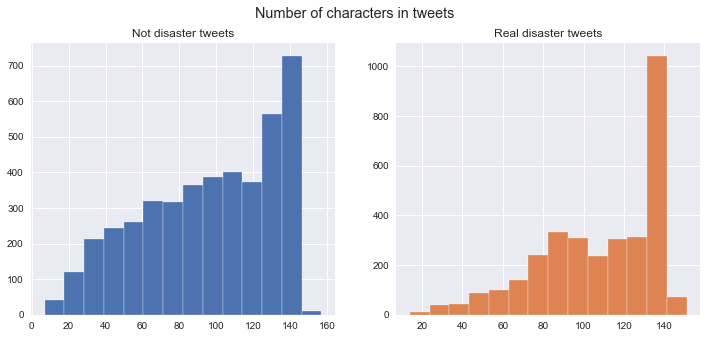

In [8]:
plt.style.use('seaborn')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))


df_tweets_len = df_train[df_train['target']==0]['text'].apply(len) # we use the .apply() method, therefore vectorization, for computational time purposes

# other method :
# tweet_len=df_train[df_train['target']==0]['text'].str.len()

ax1.hist(x=df_tweets_len,
         bins=14,
         color=customized_palette[0])
ax1.set_title('Not disaster tweets')

df_tweets_len = df_train[df_train['target']==1]['text'].apply(len)

ax2.hist(x=df_tweets_len,
         bins=14,
         color=customized_palette[1])
ax2.set_title('Real disaster tweets')

fig.suptitle('Number of characters in tweets')
plt.show()

Observation :

I guess most of the dataset was built when tweets could only contain up to 140 characters, and not 280 like today. (Very few have more than 140 chars, max for not disaster tweets is 157 chars, and max for real disaster tweets is 151 chars)\
The trends are pretty similar for the 2 classes, both having a peak of tweets containing [130,145] characters, close or equal to the max.

##### Analyzing this [130,145] space

In [9]:
df_tweets_len = df_train[df_train['target']==0]['text'].apply(len)
df_tweets_140_chars = df_tweets_len[(df_tweets_len>130) & (df_tweets_len<145)]
print("Amongst {} 'not disaster tweets', {} % (i.e. {} tweets) contain between 130 and 145 characters.".format(df_tweets_len.shape[0], round((100*df_tweets_140_chars.shape[0]/df_tweets_len.shape[0]),1), df_tweets_140_chars.shape[0]))

df_tweets_len = df_train[df_train['target']==1]['text'].apply(len)
df_tweets_140_chars = df_tweets_len[(df_tweets_len>130) & (df_tweets_len<145)]
print("Amongst {} 'real disaster tweets', {} % (i.e. {} tweets) contain between 130 and 145 characters.".format(df_tweets_len.shape[0], round((100*df_tweets_140_chars.shape[0]/df_tweets_len.shape[0]),1), df_tweets_140_chars.shape[0]))

Amongst 4342 'not disaster tweets', 23.5 % (i.e. 1021 tweets) contain between 130 and 145 characters.
Amongst 3271 'real disaster tweets', 34.5 % (i.e. 1130 tweets) contain between 130 and 145 characters.


Taking into account the number of samples for each class, 'real disaster tweets' are more likely to contain near or exactly the maximum number of characters allowed than 'not disaster tweets'.

### Number of words in tweets

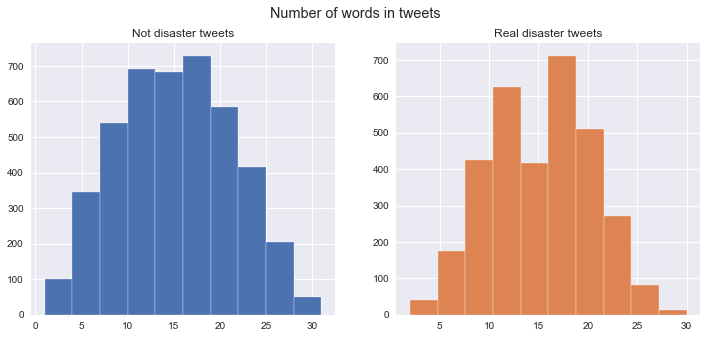

In [10]:
plt.style.use('seaborn')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

df_tweets_len = df_train[df_train['target']==0]['text'].str.split().apply(len)

# other method :
# df_tweets_len = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))

ax1.hist(df_tweets_len, color=customized_palette[0])
ax1.set_title('Not disaster tweets')

df_tweets_len = df_train[df_train['target']==1]['text'].str.split().apply(len)

ax2.hist(df_tweets_len, color=customized_palette[1])
ax2.set_title('Real disaster tweets')

fig.suptitle('Number of words in tweets')
plt.show()

Observation :

Again, the trends are pretty similar for the 2 classes, with most of the tweets containing [7,22] words.

### Average length of words in each tweet

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



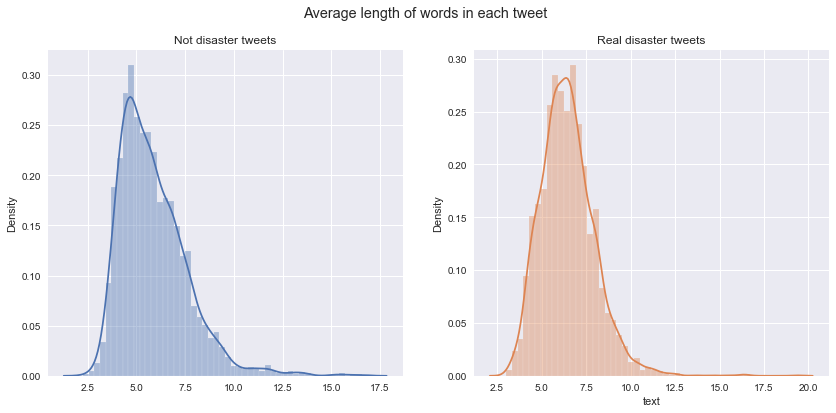

In [11]:
plt.style.use('seaborn')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

df_len_words = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(x=df_len_words.map(lambda x: np.mean(x)),
             ax=ax1,
             color=customized_palette[0])
ax1.set_title('Not disaster tweets')

df_len_words = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(df_len_words.map(lambda x: np.mean(x)),
             ax=ax2,
             color=customized_palette[1])
ax2.set_title('Real disaster tweets')

fig.suptitle('Average length of words in each tweet')
plt.show()

Observation :

The 2 classes show a very slight difference.\
Most of the 'not disaster tweets' contain words having [3,7] characters, while 'real disaster tweets' seem to contain words having [5,7.5] characters.\
Therefore, it seems that the words for the 2nd class are a bit longer.

##### The mean number of characters among the whole dataset

In [12]:
df_mean_len_words = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
print("In average, a word in a 'not disaster tweet' contains {} characters.".format(round(df_mean_len_words.mean(),2)))

df_mean_len_words = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
print("In average, a word in a 'real disaster tweet' contains {} characters.".format(round(df_mean_len_words.mean(),2)))

In average, a word in a 'not disaster tweet' contains 5.87 characters.
In average, a word in a 'real disaster tweet' contains 6.47 characters.


Our previous suspicion is verified : in average, the words in the 'real disaster tweets' are longer.

### Most common stop words

In [13]:
# It would have been interesting here to create a corpus if we plan to do differents analysis instead of going over the
# dataset multiple times.
'''
def create_corpus(target):
    corpus=[]
    
    for tweet in df_train[df_train['target']==target]['text'].str.split():
        for word in tweet:
            corpus.append(word)
    return corpus
    
corpus_class0 = create_corpus(0)
'''

"\ndef create_corpus(target):\n    corpus=[]\n    \n    for tweet in df_train[df_train['target']==target]['text'].str.split():\n        for word in tweet:\n            corpus.append(word)\n    return corpus\n    \ncorpus_class0 = create_corpus(0)\n"

In [14]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


# For class 0 : 'not disaster tweets'

dict_stopwords_class0 = {key:0 for key in list(stop_words)}

for tweet in df_train[df_train['target']==0]['text'].str.split() :
    for word in tweet :
        if (word in stop_words) :
            dict_stopwords_class0[word] += 1
            
most_common_stopwords = sorted(dict_stopwords_class0.keys(), key=lambda x : dict_stopwords_class0[x], reverse=True)[:10]

dict_stopwords_class0 = {key:dict_stopwords_class0[key] for key in most_common_stopwords}
print('Most common stop words in class 0 :\n', dict_stopwords_class0)


# For class 1 : 'real disaster tweets'

dict_stopwords_class1 = {key:0 for key in list(stop_words)}

for tweet in df_train[df_train['target']==1]['text'].str.split() :
    for word in tweet :
        if (word in stop_words) :
            dict_stopwords_class1[word] += 1
            
most_common_stopwords = sorted(dict_stopwords_class1.keys(), key=lambda x : dict_stopwords_class1[x], reverse=True)[:10]

dict_stopwords_class1 = {key:dict_stopwords_class1[key] for key in most_common_stopwords}
print('\nMost common stop words in class 1 :\n', dict_stopwords_class1)

Most common stop words in class 0 :
 {'the': 1524, 'a': 1115, 'to': 1099, 'and': 840, 'of': 834, 'in': 720, 'you': 529, 'is': 512, 'for': 452, 'my': 442}

Most common stop words in class 1 :
 {'the': 1051, 'in': 1037, 'of': 888, 'a': 730, 'to': 706, 'and': 462, 'on': 386, 'for': 368, 'is': 302, 'at': 273}


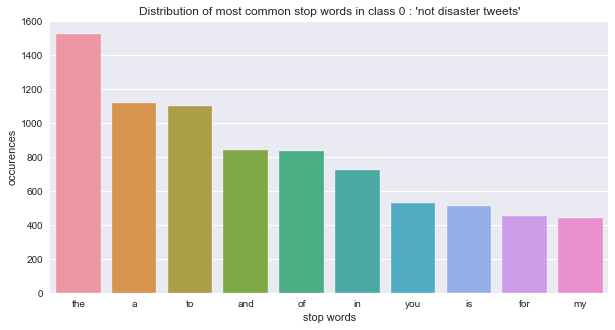

In [15]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(dict_stopwords_class0.keys()),
                 y=list(dict_stopwords_class0.values()))
ax.set(xlabel='stop words', ylabel='occurences', title='Distribution of most common stop words in class 0 : \'not disaster tweets\'')

plt.show()

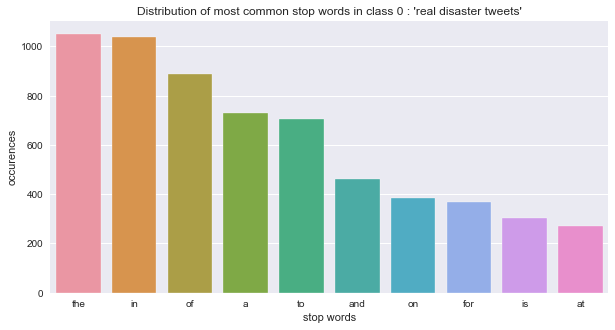

In [16]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(dict_stopwords_class1.keys()),
                 y=list(dict_stopwords_class1.values()))
ax.set(xlabel='stop words', ylabel='occurences', title='Distribution of most common stop words in class 0 : \'real disaster tweets\'')

plt.show()

Observation :

'The' dominates the ranking for both classes.\
Stop words are usually considered as meaningless data: not containing useful information to help classifying the tweets.\
Removing them also improves the processing time.\
We will see how we deal with them further in the notebook.

### Homemade preprocessing analysis

In [17]:
from homemade_preprocessing import Tokenizer

# For class 0 : 'not disaster tweets'

corrections_class0 = Tokenizer()

for tweet in df_train[df_train['target']==0]['text'].str.split() :
    for word in tweet :
        corrections_class0.test_word(word)

print('Corrections in class 0 :\n', corrections_class0._result)


# For class 1 : 'real disaster tweets'

corrections_class1 = Tokenizer()

for tweet in df_train[df_train['target']==1]['text'].str.split() :
    for word in tweet :
        corrections_class1.test_word(word)

print('\nCorrections in class 1 :\n', corrections_class1._result)

Corrections in class 0 :
 {'tag': 1798, 'hashtag': 1683, 'laughs': 47, 'smileys': 14, 'extensions': 0, 'website': 2196, 'time': 40, 'date': 3, 'mail': 1}

Corrections in class 1 :
 {'tag': 872, 'hashtag': 1691, 'laughs': 14, 'smileys': 4, 'extensions': 0, 'website': 2510, 'time': 92, 'date': 20, 'mail': 0}


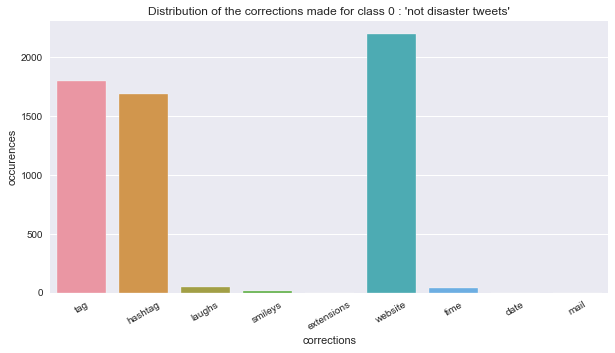

In [18]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(corrections_class0._result.keys()),
                 y=list(corrections_class0._result.values()))
ax.set(xlabel='corrections', ylabel='occurences', title='Distribution of the corrections made for class 0 : \'not disaster tweets\'')
ax.set_xticklabels(list(corrections_class0._result.keys()), rotation=30)

plt.show()

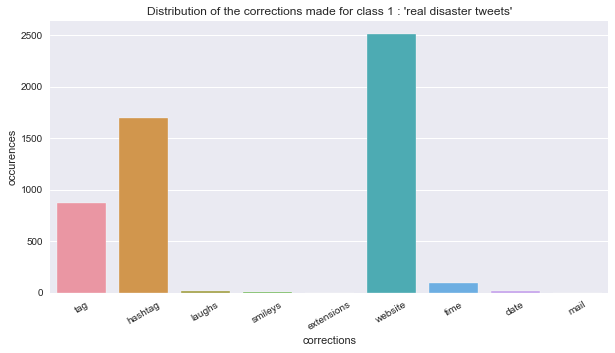

In [19]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(corrections_class1._result.keys()),
                 y=list(corrections_class1._result.values()))
ax.set(xlabel='corrections', ylabel='occurences', title='Distribution of the corrections made for class 1 : \'real disaster tweets\'')
ax.set_xticklabels(list(corrections_class1._result.keys()), rotation=30)

plt.show()

Observations :

The corrections may vary a bit depending on the tokenization method we adopt. The homemade_preprocessing script was built for a tokenization using the .split() method, which considers 'fire.' as 1 token, while word_tokenization() from nltk or SpaCy would consider 2 tokens 'fire' and '.' .\
We can see that a lot of tweets contain tags (ex : '@johnHarris'), hashtags (ex : #blablabla) and websites (ex : http://t.co/gibberish). \
No corrections seem to be very different from a class to another, except maybe for tags that seem to appear more often in class 0, and websites that seem to appear more often in real disasters, which could make sense : users would want to link more 'reliable' sources to their tweets claiming a disaster is going on.<br><br>
Some other minor corrections were made, like laughs (ex : hahaha) (see the homemade_preprocessing.py file for more details).

### Most common words

In [20]:
from collections import  Counter

def create_corpus(target):
    corpus = []
    
    for tweet in (df_train[df_train['target']==target]['text'].str.split()) :
        for word in tweet:
            corpus.append(word)
    return corpus
    
corpus_class0 = create_corpus(0)

counter = Counter(corpus_class0)
counter_most_common = counter.most_common()

x = []
y = []
i = 0
while len(x)<10 :
    word = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (word not in stop_words) :
        x.append(word)
        y.append(count)
    i+=1

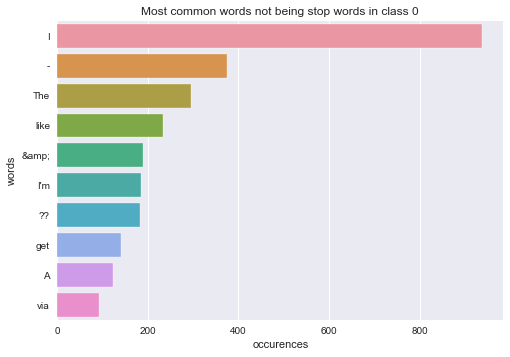

In [21]:
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='occurences', ylabel='words', title='Most common words not being stop words in class 0')

plt.show()

### Most common bi-grams

In [22]:
def create_corpus_bigrams(target):
    corpus = []
    
    for tweet in (df_train[df_train['target']==target]['text'].str.split()) :
        for i in range (len(tweet) - 1) :
            corpus.append( (tweet[i],tweet[i+1]) )
    return corpus
    
corpus_bigrams_class0 = create_corpus_bigrams(0)

counter = Counter(corpus_bigrams_class0)
counter_most_common = counter.most_common()

x = []
y = []
i = 0
while len(x)<10 :
    bigram = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (bigram[0] not in stop_words) or (bigram[1] not in stop_words) :
        x.append(bigram[0] + ' ' + bigram[1])
        y.append(count)
    i+=1

'''
Other method from internet, using CountVectorizer() from sklearn (not tested) :

from sklearn.feature_extraction.text import CountVectorizer

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # corpus of single words
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
'''

"\nOther method from internet, using CountVectorizer() from sklearn (not tested) :\n\nfrom sklearn.feature_extraction.text import CountVectorizer\n\ndef get_top_tweet_bigrams(corpus, n=None):\n    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # corpus of single words\n    bag_of_words = vec.transform(corpus)\n    sum_words = bag_of_words.sum(axis=0) \n    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]\n    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)\n    return words_freq[:n]\n\nplt.figure(figsize=(10,5))\ntop_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]\nx,y=map(list,zip(*top_tweet_bigrams))\nsns.barplot(x=y,y=x)\n"

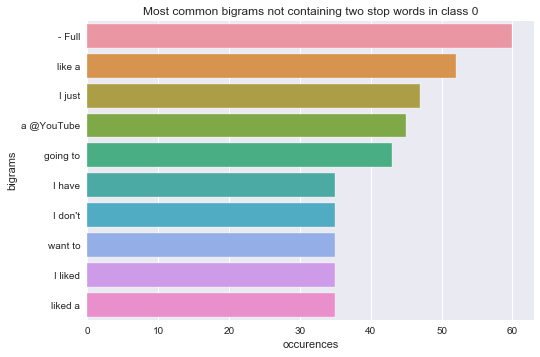

In [23]:
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='occurences', ylabel='bigrams', title='Most common bigrams not containing two stop words in class 0')

plt.show()

______________

### Class distribution among the different keywords

In [ ]:
dico = dict(zip(df_train['keyword'].unique() , np.arange(len(df_train['keyword'].unique()))))
dico_mapping_keywords = dict(zip(np.arange(len(df_train['keyword'].unique())) , df_train['keyword'].unique()))

arr=[]
for i in range (len(df_train)):
    arr.append(dico[df_train.iloc[i]['keyword']])
    
df = pd.DataFrame(data={'keyword_str':df_train['keyword'] , 'keyword':np.array(arr) , 'target':df_train['target']})



dist = []
for ind in (list(dico.keys())[1:21]) :
    dist_int = list(df[df['keyword_str'] == ind]['target'].value_counts(normalize=True))
    if (len(dist_int) == 1):
        dist_int.append(0)
    dist.append( dist_int[0] )
    dist.append( dist_int[1] )

df = pd.DataFrame(data={'keyword':np.array([[a,a] for a in list(dico.keys())[1:21] ]).reshape(40) , 'target':[0,1]*20 , 'distrib':dist})
#print(df)
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="keyword", y="distrib", hue="target", data=df)
ax.set_xticklabels(list(dico.keys())[1:21], rotation=30)

plt.show()

We're now going to build our own test set so we don't need to submit to Kaggle to have an overview of our model performances.
We only have 7613 example, so we'll take 20% of our train set.

In [ ]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

We now have 6090 examples for our train set, and 1523 examples for the test set.

In [ ]:
'''
# Preprocessing

from nltk.tokenize import word_tokenize
# nltk.download('punkt')

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

homemade_tokenizer = Tokenizer()

for i in range (len(X_train)):
    if (i%1000 == 0):
        print(i, 'off', len(X_train))
    tweet = X_train.iloc[i]['text']
    
    # 1. lowercase (to reduce the vocabulary size)
    
    tweet = tweet.lower()
    
    
    # 2. remove stop words using list from nltk (considered as useless data and to improve processing time)
    
    tweet_split_processed = [word for word in tweet.split() if not word in stop_words]
    #tweet = ' '.join(tweet_split_processed)
    
    # 3. lemmatization using spacy
    
    for j in range (len(tweet_split_processed)) :
        doc = nlp(tweet_split_processed[j])
        for token in doc:
            if (token.text != token.lemma_) :
                tweet_split_processed[j] = token.lemma_
        
        # 4. homemade preprocessing to identify websites, hashtags, person tags, etc.
        
        tweet_split_processed[j] = homemade_tokenizer.test_word(tweet_split_processed[j])
        
    
    # add changes to dataset
    X_train.at[X_train.index[i],'text'] = ' '.join(tweet_split_processed)

   
    
#TODO : homemade_tokenizer se fait sur le tweet.split() et non après tokenization --> moins efficace ?
#       lemmatization sur tokenization peut créer des problemes quand len(tweet_split_processed[j]) != len(doc). Ex '1945.'
#       Example concret dans 2ème tweet ou 'flames.' devient 'flame', pareil 4eme tweet 'you?' devient '-PRON-'

                
    #print(' '.join(tweet_split_processed))
    #print('\n\n')
'''

In [ ]:
X_train.head(15)

In [ ]:
# Create features set (vectorization)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1))
X_train_features = tfidf_vectorizer.fit_transform(X_train['text'])

tfidf_vectorizer_test = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1), vocabulary=tfidf_vectorizer.vocabulary_)
X_test_features = tfidf_vectorizer_test.fit_transform(X_test['text'])

print('vocabulary size : ', len(tfidf_vectorizer.vocabulary_))

In [ ]:
# Define and train classifier + prediction

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())

f1_score(y_test, y_pred)

In [ ]:
# Most valued features by the LogReg classifier

print('LogReg params : \n', clf.get_params(), '\n')

arr = np.reshape(clf.coef_, clf.coef_.shape[1])
n = 10
arr_n_indexes = np.argsort(arr)[-n:][::-1]

for i in range (n) :
    print(tfidf_vectorizer.get_feature_names()[arr_n_indexes[i]], arr[arr_n_indexes[i]])


In [ ]:
'''
# Prediction on test set + csv

tfidf_vectorizer_testset = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1), vocabulary=tfidf_vectorizer.vocabulary_)
X_testset_features = tfidf_vectorizer_testset.fit_transform(df_test['text'])

y_pred_testset = clf.predict(X_testset_features.toarray())

df_submission = pd.DataFrame(data={'id':df_test['id'], 'target':y_pred_testset})
df_submission.to_csv('Tfidf_+_LogReg.csv', index=False)
'''

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

In [ ]:
from sklearn.svm import SVC

clf = SVC(random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

In [ ]:
from sklearn.neural_network import MLPClassifier

#clf = MLPClassifier(hidden_layer_sizes=(10, 128, 2), random_state=42, max_iter=300)
clf = MLPClassifier(hidden_layer_sizes=(5,), random_state=42, max_iter=10)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

In [ ]:
# baseline

y_pred = np.random.randint(2, size=len(y_test))
f1_score(y_test, y_pred)